# Decoding the Bottle: A Sociological and Operational Analysis of Alcohol Distribution
Author: Jorge Reyes-Ornelas

Objective: To investigate the mismatch between retail consumer demand ("Pull") and warehouse-driven distribution ("Push"), while identifying operational inefficiencies such as "Dead Stock."

# The Sociology of the Supply Chain
In the wine and spirits industry, "taste" is not just a personal preference; it is a socially constructed phenomenon. Utilizing my background in sociology and wine operations, this project analyzes a distribution dataset to see where Individual Agency (Retail Sales) diverges from Institutional Habit (Warehouse Sales).

We will use SQL to clean the data, identify market outliers, and pinpoint operational "dead stock"—items that are transferred to stores but fail to reach the consumer.

In [1]:
import duckdb
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load SQL extension and connect to DuckDB
%load_ext sql
%sql duckdb:///:memory:

# Load the dataset
%sql CREATE TABLE sales AS SELECT * FROM 'Warehouse_and_Retail_Sales.csv';

Connecting to 'duckdb:///:memory:'

Running query in 'duckdb:///:memory:'

Count


### Section 1: Filtering for "For-Sale" Inventory
A critical step in operations is distinguishing between commercial products and internal supplies. Preliminary inspection shows items like "Paper Bags" in the dataset. Since these are not consumer products, we must filter them out to ensure our sales analysis is accurate.

In [2]:
%%sql
-- Create a cleaned view of the data
CREATE OR REPLACE VIEW cleaned_sales AS
SELECT * FROM sales 
WHERE "ITEM DESCRIPTION" NOT LIKE '%BAGS%' 
  AND "ITEM DESCRIPTION" NOT LIKE '%PAPER%'
  AND "RETAIL SALES" > 0;

Running query in 'duckdb:///:memory:'

Count


### Section 2: Retail Favorites vs. Warehouse WorkhorsesHere, 
we use Window Functions to rank items.
* Rank Gap $> 0$: "Retail Stars" (Consumer-driven demand). 
* Rank Gap $< 0$: "Institutional Pours" (Distributor-driven demand). 

From a sociological perspective, a high positive gap suggests an "Authenticity" trend where consumers are specifically seeking out brands that the warehouse hasn't yet prioritized for bulk movement.

In [5]:
%%sql
-- Creating a View to store our ranking logic for later use
CREATE OR REPLACE VIEW wine_rankings_view AS
WITH WineAggs AS (
    SELECT 
        "ITEM DESCRIPTION",
        "SUPPLIER",
        SUM("RETAIL SALES") AS total_retail,
        SUM("WAREHOUSE SALES") AS total_warehouse
    FROM cleaned_sales
    WHERE "ITEM TYPE" = 'WINE'
    GROUP BY 1, 2
),
RankedItems AS (
    SELECT *,
        RANK() OVER(ORDER BY total_retail DESC) as retail_rank,
        RANK() OVER(ORDER BY total_warehouse DESC) as warehouse_rank
    FROM WineAggs
)
SELECT 
    *,
    (warehouse_rank - retail_rank) AS rank_gap
FROM RankedItems;

-- Displaying the Top 10 "Retail Stars"
SELECT * FROM wine_rankings_view 
ORDER BY rank_gap DESC 
LIMIT 10;

Running query in 'duckdb:///:memory:'

ITEM DESCRIPTION,SUPPLIER,total_retail,total_warehouse,retail_rank,warehouse_rank,rank_gap
CH DU RETOUT CRU BOURGEOIS '15 - 750ML,MHW LTD,17.609999999999996,-3.0,3202,8992,5790
WILLAMETTE VLY P/GRIS - 750ML,RELIABLE CHURCHILL LLLP,13.7,-1.0,3480,8986,5506
STOCK ITALIAN DRY VERMOUTH - 1.5L,LUXCO SPIRITED BRANDS,111.59,0.0,1312,6231,4919
CH ARNAUTON '15 - 750ML,CHEVAL QUANCARD,109.08,0.0,1332,6231,4899
PRESIDENTIAL LBV PORT 6/CS - 750ML,JACK POUST & COMPANY INC,96.63,0.0,1427,6231,4804
ESTRELLA P/GRIG - 1.5L,REPUBLIC NATIONAL DISTRIBUTING CO,91.51,0.0,1473,6231,4758
BOLLA AMARONE 6/C - 750ML,BANFI PRODUCTS CORP,82.7,0.0,1552,6231,4679
ST HILAIRE SPARK SEMI SW - 750ML,JACK POUST & COMPANY INC,130.5,1.0,1187,5684,4497
CHALK HILL EB CHARD - 750ML,REPUBLIC NATIONAL DISTRIBUTING CO,5.75,-1.0,4630,8986,4356
TAYLOR LAKE COUNTRY RED - 3L,REPUBLIC NATIONAL DISTRIBUTING CO,108.5,1.0,1337,5684,4347


### Section 3: Visualizing the Efficiency Gap
While the table provides raw numbers, a visualization allows us to see the structural distribution of the wine market.

We will pull the data from our SQL wine_rankings_view into a Pandas DataFrame. We use a Logarithmic Scale for the axes because sales volumes in alcohol distribution often follow a "Power Law" (a few items sell in the millions, while thousands sell in small quantities).

The Red Diagonal Line represents a perfectly efficient market where warehouse supply perfectly matches retail demand. Points falling far below the line represent the operational friction we are investigating.

Running query in 'duckdb:///:memory:'

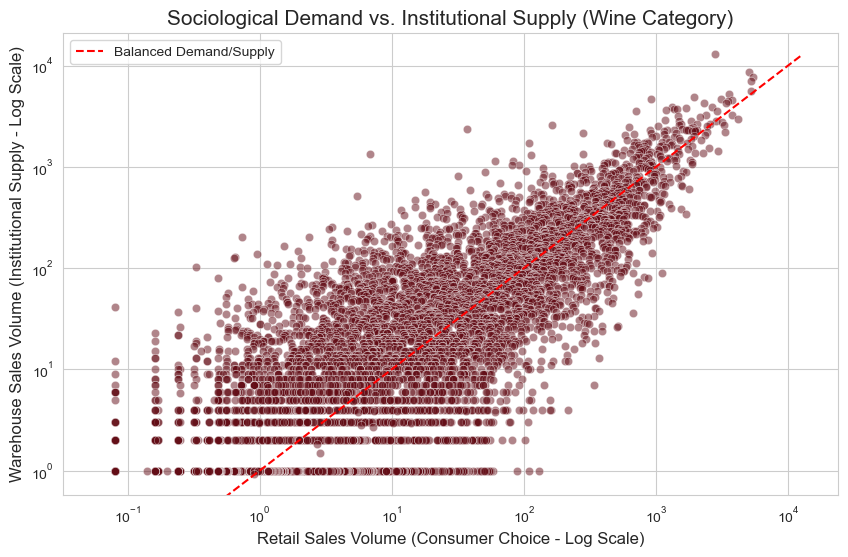

In [6]:
# 1. Pull the data from the SQL View into a Pandas DataFrame
df_plot = %sql SELECT * FROM wine_rankings_view
df_plot = df_plot.DataFrame()

# 2. Setup the visualization
plt.figure(figsize=(10, 6))
sns.set_style("whitegrid")

# 3. Create the scatter plot
plot = sns.scatterplot(
    data=df_plot, 
    x='total_retail', 
    y='total_warehouse', 
    alpha=0.5, 
    color='#630d16' # A "Wine Red" color for theme consistency
)

# 4. Add the "Perfect Balance" 1:1 Reference Line
max_val = max(df_plot['total_retail'].max(), df_plot['total_warehouse'].max())
plt.plot([0, max_val], [0, max_val], color='red', linestyle='--', label='Balanced Demand/Supply')

# 5. Apply Log Scale for better visibility of the "Long Tail"
plt.xscale('log')
plt.yscale('log')

# 6. Labeling for Portfolio Clarity
plt.title('Sociological Demand vs. Institutional Supply (Wine Category)', fontsize=15)
plt.xlabel('Retail Sales Volume (Consumer Choice - Log Scale)', fontsize=12)
plt.ylabel('Warehouse Sales Volume (Institutional Supply - Log Scale)', fontsize=12)
plt.legend()

plt.show()

### Sociological Synthesis
The visualization reveals a dense cluster of products in the lower-left quadrant: the Long Tail of the wine market.

From a sociological perspective, the "Retail Stars" (items in the bottom-right) represent Cultural Capital. These are often premium or niche varietals that consumers choose to signal status or taste, yet they are under-indexed in the warehouse's bulk operations.

Conversely, the "Warehouse Workhorses" (top-left) represent Institutionalized Taste. These wines dominate the supply chain not because consumers choose them at a shelf, but because they are the standard offerings in institutional settings (hotels, banquet halls, and large-scale hospitality).

## Section 4: Identifying "Dead Stock"
In operations, Retail Transfers ($T$) represent inventory moved from the warehouse to the store. 
If $T >> S$ (where $S$ is Retail Sales), we have an operational failure. This inventory occupies shelf space without generating revenue.
Mathematically, we define the Operational Efficiency Gap ($E$) 
as:$$E = \text{Transfers} - \text{Sales}$$

In [5]:
%%sql
SELECT 
    "ITEM DESCRIPTION",
    "SUPPLIER",
    SUM("RETAIL TRANSFERS") AS total_transfers,
    SUM("RETAIL SALES") AS total_sales,
    (SUM("RETAIL TRANSFERS") - SUM("RETAIL SALES")) AS dead_stock_volume
FROM cleaned_sales
GROUP BY 1, 2
HAVING dead_stock_volume > 100
ORDER BY dead_stock_volume DESC
LIMIT 10;

Running query in 'duckdb:///:memory:'

ITEM DESCRIPTION,SUPPLIER,total_transfers,total_sales,dead_stock_volume
EVAN WILLIAMS EGG NOG - 750ML,HEAVEN HILL DISTILLERIES INC,772.75,444.15999999999997,328.59000000000003
TITO'S HANDMADE VODKA - 1.75L,FIFTH GENERATION INC,27889.33,27580.5,308.83000000000175
WHITE CLAW VARIETY PACK #2 2/12PK 12.OZ CAN,MARK ANTHONY BRANDS INC,691.0,387.0,304.0
WHITE CLAW VARIETY PACK 2/12PK 12.OZ CAN,MARK ANTHONY BRANDS INC,2630.0,2349.62,280.3800000000001
TRULY LEMONADE SELTZER VARIETY 12PK 120Z CAN,BOSTON BEER CORPORATION,742.0,470.5,271.5
TRULY VARIETY 24PK LOOSE CANS,BOSTON BEER CORPORATION,1024.0,789.0,235.0
CORONA SELTZER VARIETY 2/12 CAN,CROWN IMPORTS,1061.0,834.36,226.64
JAMESON IRISH WHISKEY - 750ML,PERNOD RICARD USA LLC,4004.9300000000003,3801.74,203.1900000000005
TRULY SPIKED & SPARKLING BERRY VARIETY 12 PK CAN,BOSTON BEER CORPORATION,2356.0,2181.04,174.96000000000004
GOSLING DK & STORMY W/GINGER BEER - 750ML,CASTLE BRANDS USA CORP,222.67000000000002,56.980000000000004,165.69


## Final Sociological & Operational Synthesis
This project demonstrates that alcohol distribution is not a perfectly efficient market.

Operational Insight: High "Dead Stock" volume in specific seasonal items (e.g., Egg Nog) suggests a need for better predictive modeling in "training and operations" to prevent over-transferring.

Sociological Insight: The mismatch between retail and warehouse ranks confirms that consumer "cultural capital" moves faster than institutional supply chains.

By using SQL to bridge these two worlds, we can optimize inventory while staying ahead of shifting social trends in the wine industry.